In [1]:
# а тут мы попробуем что то поинтереснее, а точнее ннейронные сети

In [22]:
import csv

# loading some training data and deleting labels

data = []
labels = []

with open('data/swiss_dialect/train.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row[0])
        labels.append(row[1])
        
data.pop(0)
labels.pop(0)

testing_data = []
testing_labels = []

with open('data/swiss_dialect/test.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        testing_data.append(row[1])
        
testing_data.pop(0)

with open('data/swiss_dialect/test.GOLD.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        testing_labels.append(row[1])

testing_labels.pop(0)


print(f" Всего данных для обучения: {len(data)}, признаков: {len(labels)} ")
print(f" Тестовых данных: {len(testing_data)}, признаков: {len(testing_labels)} ")

 Всего данных для обучения: 15616, признаков: 15616 
 Тестовых данных: 2500, признаков: 2500 


In [23]:
# тут мы будем использовать другой тип токенизации, с сохранением позиций слов
# для сохранения большего кол-ва информации и нахождения новых смыслов

import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_encoded_labels = label_encoder.fit_transform(labels)
test_encoded_labels = label_encoder.fit_transform(testing_labels)

train_labels = np.array(train_encoded_labels)
test_labels = np.array(test_encoded_labels)

train_1hot_labels = np.eye(4)[train_labels] # понадобится в будущем
test_1hot_labels = np.eye(4)[test_labels]

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

tokenized_Text1 = [word_tokenize(message) for message in data]
tokenized_Text2 = [word_tokenize(message) for message in testing_data]

all_tokens = []
for message in tokenized_Text1:
    all_tokens.extend(message)

for message in tokenized_Text2:
    all_tokens.extend(message)

all_tokens_set = set(all_tokens)

In [24]:
word_to_id = {word: idx for idx, word in enumerate(all_tokens_set)}
numeric_ids = [word_to_id[word] for word in all_tokens_set] 
idc_Text = [[word_to_id[word] for word in tokens] for tokens in tokenized_Text1]
idc_test =  [[word_to_id[word] for word in tokens] for tokens in tokenized_Text2]

In [25]:
# наши предложения имеют различную длинну, необходимо их привести к общему виду
lengths_train_Text = [len(arr) for arr in idc_Text]
lengths_test_Text = [len(arr) for arr in idc_test]
average_length_Text = (sum(lengths_train_Text) + sum(lengths_test_Text)) / (len(lengths_train_Text) + len(lengths_test_Text))

max_length_Text = max(lengths_train_Text)
max_length_test_Text =  max(lengths_test_Text)


print(f"max len: {max_length_Text} {max_length_test_Text}, average len: {average_length_Text}")

max len: 54 43, average len: 7.957164937072202


In [26]:
# заполняем свободные места загушками
id_to_word = {v: k for k, v in word_to_id.items()}

fill_value = len(id_to_word) 
desired_length = max_length_Text  

id_to_word[fill_value] = 'pepe'

def fill_array(array, fill_value, desired_length):
    for sub_array in array:
        if len(sub_array) < desired_length:
            while len(sub_array) < desired_length:
                sub_array.append(fill_value)
    return array

completed_idc_Text = fill_array(idc_Text, fill_value, desired_length)
completed_idc_test_Text = fill_array(idc_test, fill_value, desired_length)

In [27]:
# теперь у нас все записано в виде векторов одинаковой длинны

lengths_train_Text = [len(arr) for arr in idc_Text]
lengths_test_Text = [len(arr) for arr in idc_test]
average_length_Text = (sum(lengths_train_Text) + sum(lengths_test_Text)) / (len(lengths_train_Text) + len(lengths_test_Text))

max_length_Text = max(lengths_train_Text)
max_length_test_Text =  max(lengths_test_Text)


print(f"max len: {max_length_Text} {max_length_test_Text}, average len: {average_length_Text}")

max len: 54 54, average len: 54.0


In [28]:
X_train = np.array(completed_idc_Text)
X_test = np.array(completed_idc_test_Text)

In [29]:
# сперва попробуем простую RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.layers import SimpleRNN
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


rnn_model = Sequential()
rnn_model.add(Embedding(len(id_to_word), 64))
rnn_model.add(SimpleRNN(64, return_sequences=True)) 
rnn_model.add(SimpleRNN(64)) 
rnn_model.add(Dense(4, activation='softmax')) 

rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = rnn_model.fit(X_train, train_1hot_labels, epochs=25, batch_size=32, validation_data = (X_test, test_1hot_labels ))

Epoch 1/25
488/488 [==============================] - 11s 18ms/step - loss: 1.1590 - accuracy: 0.4885 - val_loss: 0.8853 - val_accuracy: 0.6564
Epoch 2/25
488/488 [==============================] - 9s 18ms/step - loss: 0.7837 - accuracy: 0.7041 - val_loss: 0.8832 - val_accuracy: 0.6560
Epoch 3/25
488/488 [==============================] - 10s 21ms/step - loss: 0.5990 - accuracy: 0.7883 - val_loss: 0.7337 - val_accuracy: 0.7436
Epoch 4/25
488/488 [==============================] - 15s 31ms/step - loss: 0.4938 - accuracy: 0.8312 - val_loss: 0.8947 - val_accuracy: 0.6820
Epoch 5/25
488/488 [==============================] - 10s 21ms/step - loss: 0.4211 - accuracy: 0.8600 - val_loss: 0.7636 - val_accuracy: 0.7572
Epoch 6/25
488/488 [==============================] - 10s 20ms/step - loss: 0.3599 - accuracy: 0.8831 - val_loss: 0.8698 - val_accuracy: 0.7656
Epoch 7/25
488/488 [==============================] - 11s 22ms/step - loss: 0.3192 - accuracy: 0.8963 - val_loss: 0.7538 - val_accuracy: 

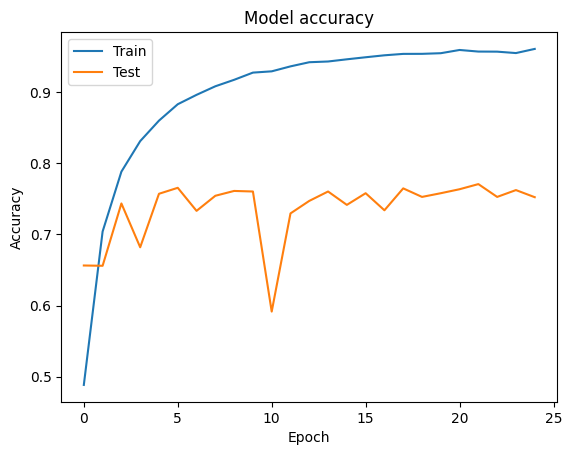

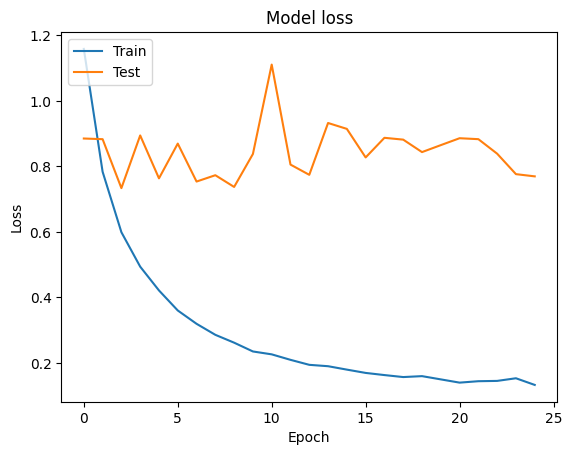

In [31]:
import matplotlib.pyplot as plt

# Построение графика точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
# попробуем lstm

lstm_model = Sequential()
lstm_model.add(Embedding(len(id_to_word), 64))
lstm_model.add(LSTM(64, return_sequences=True),  ) 
lstm_model.add(LSTM(32))
lstm_model.add(Dense(4, activation='softmax')) 

lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = lstm_model.fit(X_train, train_1hot_labels, epochs=25, batch_size=32, validation_data = (X_test, test_1hot_labels ))

Epoch 1/25
488/488 [==============================] - 21s 35ms/step - loss: 1.3854 - accuracy: 0.2679 - val_loss: 1.3845 - val_accuracy: 0.2700
Epoch 2/25
488/488 [==============================] - 19s 38ms/step - loss: 1.3848 - accuracy: 0.2659 - val_loss: 1.3847 - val_accuracy: 0.2700
Epoch 3/25
488/488 [==============================] - 18s 37ms/step - loss: 1.3845 - accuracy: 0.2715 - val_loss: 1.3855 - val_accuracy: 0.2588
Epoch 4/25
488/488 [==============================] - 18s 38ms/step - loss: 1.3844 - accuracy: 0.2656 - val_loss: 1.3846 - val_accuracy: 0.2700
Epoch 5/25
488/488 [==============================] - 18s 37ms/step - loss: 1.3846 - accuracy: 0.2593 - val_loss: 1.3844 - val_accuracy: 0.2700
Epoch 6/25
488/488 [==============================] - 19s 39ms/step - loss: 1.3843 - accuracy: 0.2675 - val_loss: 1.3849 - val_accuracy: 0.2588
Epoch 7/25
488/488 [==============================] - 21s 42ms/step - loss: 1.3843 - accuracy: 0.2668 - val_loss: 1.3846 - val_accuracy:

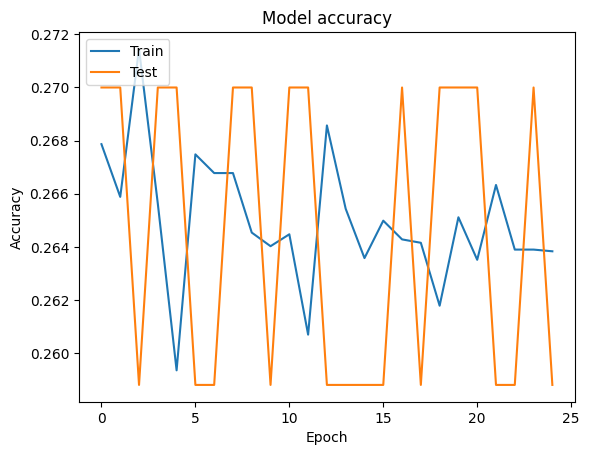

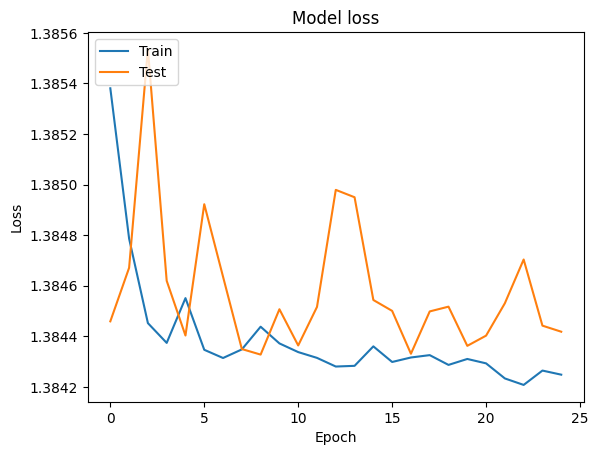

In [34]:
import matplotlib.pyplot as plt

# Построение графика точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
# простая полносвязная модель

from tensorflow.keras.layers import GlobalAveragePooling1D

ffn_model = Sequential()
ffn_model.add(Embedding(len(id_to_word), 64))
ffn_model.add(GlobalAveragePooling1D())
ffn_model.add(Dense(64, activation='relu')) 
ffn_model.add(Dense(32, activation='relu')) 
ffn_model.add(Dense(4, activation='softmax'))

ffn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
history = ffn_model.fit(X_train, train_1hot_labels, epochs=25, batch_size=32, validation_data = (X_test, test_1hot_labels ))

Epoch 1/25
488/488 [==============================] - 6s 10ms/step - loss: 1.3806 - accuracy: 0.2850 - val_loss: 1.3644 - val_accuracy: 0.3596
Epoch 2/25
488/488 [==============================] - 5s 9ms/step - loss: 1.1588 - accuracy: 0.5290 - val_loss: 0.9019 - val_accuracy: 0.6416
Epoch 3/25
488/488 [==============================] - 5s 10ms/step - loss: 0.7761 - accuracy: 0.6877 - val_loss: 0.7292 - val_accuracy: 0.6972
Epoch 4/25
488/488 [==============================] - 5s 9ms/step - loss: 0.6268 - accuracy: 0.7519 - val_loss: 0.6380 - val_accuracy: 0.7412
Epoch 5/25
488/488 [==============================] - 5s 10ms/step - loss: 0.5342 - accuracy: 0.7927 - val_loss: 0.5878 - val_accuracy: 0.7656
Epoch 6/25
488/488 [==============================] - 5s 11ms/step - loss: 0.4641 - accuracy: 0.8228 - val_loss: 0.5821 - val_accuracy: 0.7704
Epoch 7/25
488/488 [==============================] - 5s 10ms/step - loss: 0.4178 - accuracy: 0.8444 - val_loss: 0.5735 - val_accuracy: 0.7724
E

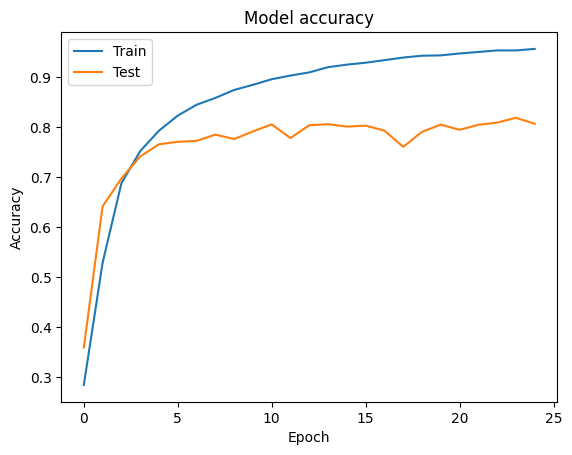

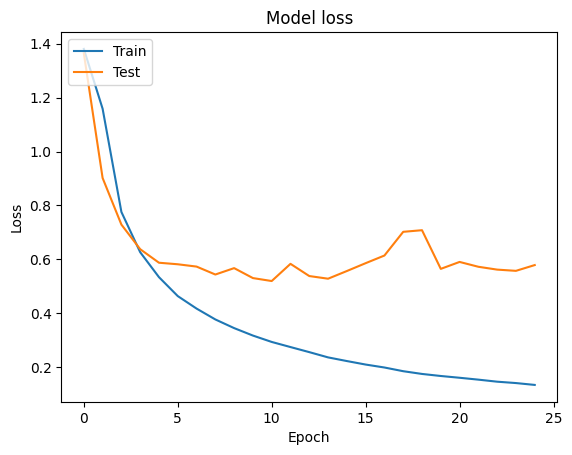

In [43]:
import matplotlib.pyplot as plt

# Построение графика точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

cnn_model = Sequential()
cnn_model.add(Embedding(len(id_to_word), 64))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(Conv1D(32, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(4, activation='softmax'))

cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = cnn_model.fit(X_train, train_1hot_labels, epochs=25, batch_size=32, validation_data = (X_test, test_1hot_labels ))

Epoch 1/25
488/488 [==============================] - 7s 13ms/step - loss: 0.9271 - accuracy: 0.5904 - val_loss: 0.6107 - val_accuracy: 0.7568
Epoch 2/25
488/488 [==============================] - 7s 14ms/step - loss: 0.4706 - accuracy: 0.8224 - val_loss: 0.5475 - val_accuracy: 0.7920
Epoch 3/25
488/488 [==============================] - 7s 15ms/step - loss: 0.3317 - accuracy: 0.8807 - val_loss: 0.5453 - val_accuracy: 0.7976
Epoch 4/25
488/488 [==============================] - 8s 16ms/step - loss: 0.2400 - accuracy: 0.9170 - val_loss: 0.5404 - val_accuracy: 0.8012
Epoch 5/25
488/488 [==============================] - 8s 15ms/step - loss: 0.1767 - accuracy: 0.9407 - val_loss: 0.5821 - val_accuracy: 0.8076
Epoch 6/25
488/488 [==============================] - 8s 15ms/step - loss: 0.1344 - accuracy: 0.9554 - val_loss: 0.7111 - val_accuracy: 0.7928
Epoch 7/25
488/488 [==============================] - 8s 16ms/step - loss: 0.1044 - accuracy: 0.9650 - val_loss: 0.7218 - val_accuracy: 0.7952

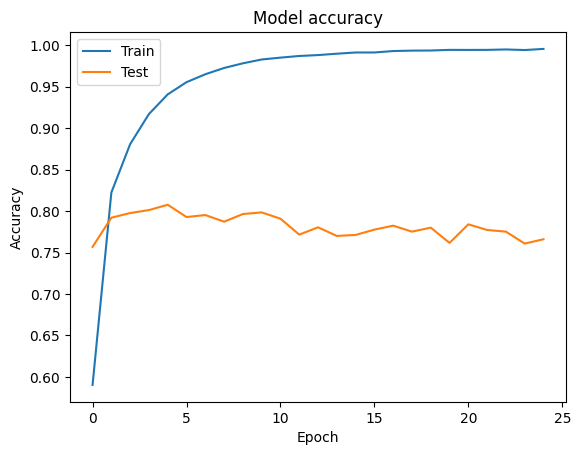

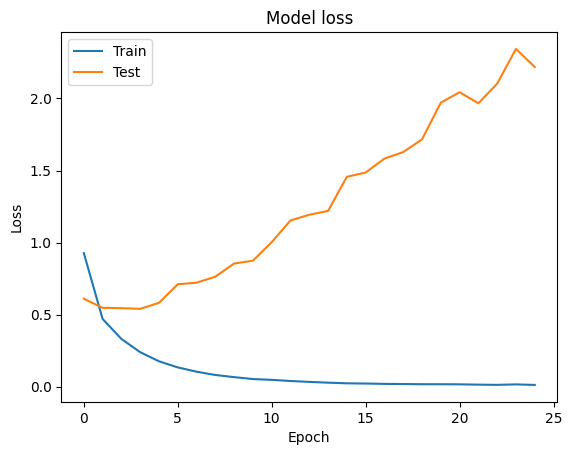

In [47]:
import matplotlib.pyplot as plt

# Построение графика точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
# а теперь моя разработка

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, SimpleRNN, Dense, Dropout

cnn_rnn_model = Sequential()
cnn_rnn_model.add(Embedding(len(id_to_word), 64))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(Conv1D(32, 3, activation='relu'))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(MaxPooling1D(5))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(SimpleRNN(64))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(Dense(64, activation='relu'))
cnn_rnn_model.add(Dropout(0.4))
cnn_rnn_model.add(Dense(4, activation='softmax'))

cnn_rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = cnn_rnn_model.fit(X_train, train_1hot_labels, epochs=40, batch_size=32, validation_data = (X_test, test_1hot_labels ))

Epoch 1/40
488/488 [==============================] - 11s 18ms/step - loss: 1.2429 - accuracy: 0.3676 - val_loss: 1.0389 - val_accuracy: 0.4824
Epoch 2/40
488/488 [==============================] - 9s 19ms/step - loss: 0.9164 - accuracy: 0.6014 - val_loss: 0.7428 - val_accuracy: 0.7064
Epoch 3/40
488/488 [==============================] - 12s 25ms/step - loss: 0.6122 - accuracy: 0.7718 - val_loss: 0.6078 - val_accuracy: 0.7600
Epoch 4/40
488/488 [==============================] - 13s 28ms/step - loss: 0.4784 - accuracy: 0.8323 - val_loss: 0.5741 - val_accuracy: 0.7764
Epoch 5/40
488/488 [==============================] - 8s 17ms/step - loss: 0.4021 - accuracy: 0.8600 - val_loss: 0.5841 - val_accuracy: 0.7804
Epoch 6/40
488/488 [==============================] - 10s 21ms/step - loss: 0.3446 - accuracy: 0.8835 - val_loss: 0.5820 - val_accuracy: 0.7824
Epoch 7/40
488/488 [==============================] - 10s 21ms/step - loss: 0.2917 - accuracy: 0.9055 - val_loss: 0.5860 - val_accuracy: 0

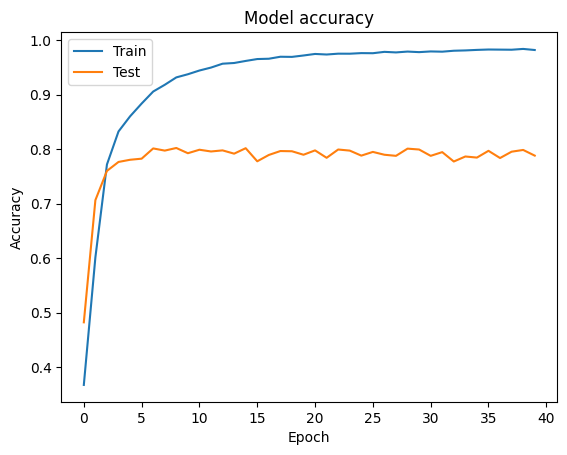

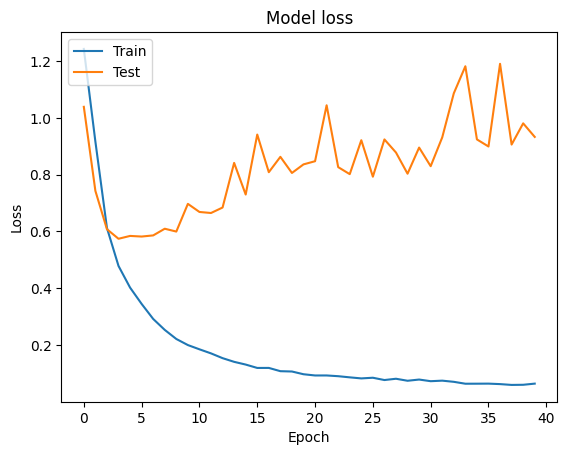

In [50]:
import matplotlib.pyplot as plt

# Построение графика точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()